In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lr.text_processing.util import pre_process_nli_df
from lr.training.util import get_ternary_label
from lr.text_processing.transformations.structural import entailment_internalization
from lr.text_processing.transformations.synonyms import toy_transformation
from lr.stats.h_testing import DGP, get_matched_results, get_paired_t_statistic
from lr.stats.h_testing import get_boot_sample_under_H0,get_boot_p_value
from lr.stats.h_testing import  LIMts_test
from lr.training.language_representation import Tfidf
from lr.models.logistic_regression import LRWrapper
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

### Loading data

In [2]:
train_path = "data/toy/train.csv"
dev_path = "data/toy/dev.csv"
train = pd.read_csv(train_path)
dev = pd.read_csv(dev_path)
pre_process_nli_df(train)
pre_process_nli_df(dev)

### Training a model using one version of the modified data

In [3]:
max_features = 500
rho = 0.001
label_translation = get_ternary_label
transformation = entailment_internalization 

dgp = DGP(data=train, transformation=transformation, rho=rho)
train_t = dgp.get_sample()

hyperparams = {"RepresentationFunction": Tfidf,
               "max_features": max_features,
               "label_translation": label_translation,
               "penalty": "l2",
               "C": 1,
               'solver': 'lbfgs'}
lr = LRWrapper(hyperparams)
lr.fit(train_t)

### Get t statistic for the observable results and matched results

In [4]:
dev_t = transformation(dev)

results = get_matched_results(dev, dev_t, lr, lr.label_translation)
t_obs = get_paired_t_statistic(results)

print(t_obs)

-1.2964074471043285


### Get $S$ bootstrap replications under H0

In [5]:
S = 1000
t_boots = []
for _ in range(S):
    boot_sample = get_boot_sample_under_H0(results)
    t = get_paired_t_statistic(boot_sample)
    t_boots.append(t)

t_boots = pd.Series(t_boots)

### Calculating the associated p-value

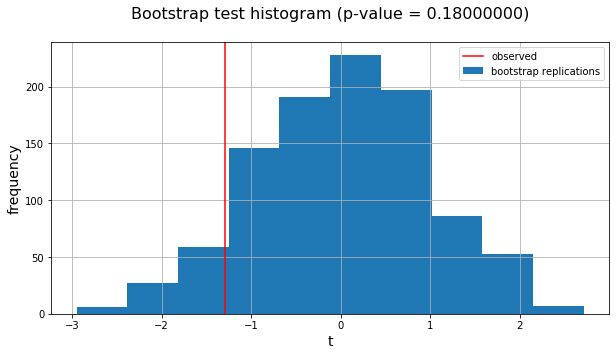

In [6]:
p_value = get_boot_p_value(t_boots, t_obs)

fig, ax = plt.subplots(figsize=(10,5))
t_boots.hist(ax=ax, label="bootstrap replications");
plt.axvline(x=t_obs, color='r', linestyle='-', label="observed");
ax.set_xlabel("t", fontsize=14);
ax.set_ylabel("frequency", fontsize=14);
ax.set_title("Bootstrap test histogram (p-value = {:.8f})".format(p_value) +"\n", fontsize=16)
plt.legend(loc="best");

### Performing multiple tests

**test1: entailment internalization**

In [7]:
M,E,S = 5,1,1000


tests1 = LIMts_test(train=train,
                    dev=dev,
                    transformation=entailment_internalization,
                    rho=0.78,
                    Model=LRWrapper,
                    hyperparams=hyperparams,
                    M=M,
                    E=E,
                    S=S)

tests1

,m,e,validation_accuracy,transformed_validation_accuracy,observable_t_stats,p_value,transformation_time,training_time,test_time,boot_t_1,...,boot_t_991,boot_t_992,boot_t_993,boot_t_994,boot_t_995,boot_t_996,boot_t_997,boot_t_998,boot_t_999,boot_t_1000
0,1,1,0.285,0.525,-7.947194,0.0,0.013366,0.060534,2.307883,-0.142864,...,2.043608,1.783315,-1.112830,-0.555127,1.318761,1.239156,-1.002509,-0.686803,-0.294948,0.899843
1,2,1,0.300,0.540,-7.947194,0.0,0.006512,0.055785,2.442291,0.152507,...,-1.112830,0.262658,0.000000,1.023727,1.053361,-1.002509,-0.288735,-0.420269,1.046351,-1.581221
2,3,1,0.315,0.545,-7.729182,0.0,0.005711,0.051252,2.363859,-0.534905,...,-0.420269,0.277403,0.000000,-0.149079,0.160138,0.149079,-0.746393,0.308680,-1.450953,-0.288735
3,4,1,0.305,0.550,-8.056095,0.0,0.006003,0.067814,2.259454,-1.960008,...,0.544735,0.633089,1.367172,-1.370776,-0.468779,-1.887416,0.000000,0.457735,0.404686,1.558573
4,5,1,0.325,0.580,-8.273837,0.0,0.005707,0.054465,2.313537,-0.420269,...,0.000000,1.239156,-1.585549,-0.272216,-2.043608,1.046351,1.614943,0.566139,-0.134846,0.142864


### Diferent bootstrap distributions for each experiment

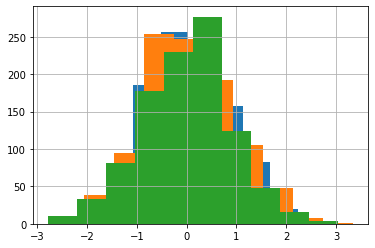

In [8]:
tests1.iloc[0][["boot_t_{}".format(i+1) for i in range(S)]].hist();
tests1.iloc[2][["boot_t_{}".format(i+1) for i in range(S)]].hist();
tests1.iloc[3][["boot_t_{}".format(i+1) for i in range(S)]].hist();

**test2: toy transformation**

In [9]:
tests2 = LIMts_test(train=train,
                   dev=dev,
                   transformation=toy_transformation,
                   rho=0.78,
                   Model=LRWrapper,
                   hyperparams=hyperparams,
                   M=M,
                   E=E,
                   S=S)

tests2

,m,e,validation_accuracy,transformed_validation_accuracy,observable_t_stats,p_value,transformation_time,training_time,test_time,boot_t_1,...,boot_t_991,boot_t_992,boot_t_993,boot_t_994,boot_t_995,boot_t_996,boot_t_997,boot_t_998,boot_t_999,boot_t_1000
0,1,1,0.230,0.220,0.577832,0.532,0.006033,0.045222,2.425029,0.000000,...,0.833494,1.150871,-1.002509,0.577832,-1.822336,-0.277403,-0.534905,-1.347719,1.296407,-0.277403
1,2,1,0.210,0.205,0.277403,0.798,0.003642,0.047525,2.351373,-1.393466,...,-1.508509,0.728572,1.914677,1.002509,0.333426,-0.707992,-0.258242,0.471667,-1.002509,-0.577832
2,3,1,0.205,0.220,-1.347719,0.224,0.003916,0.055310,2.532464,-0.707992,...,-1.347719,1.002509,-0.577832,-1.745189,-2.020305,0.000000,-0.447437,-0.577832,1.002509,0.577832
3,4,1,0.205,0.215,-0.633089,0.520,0.004526,0.044667,2.400237,-1.270001,...,0.333426,0.817861,-1.508509,-1.678363,-0.906390,-2.340823,1.072113,0.471667,0.000000,-0.833494
4,5,1,0.220,0.225,-0.447437,0.766,0.003872,0.044157,2.338308,-1.643990,...,-0.577832,1.002509,-0.577832,-1.347719,-0.447437,0.577832,0.447437,-1.002509,0.000000,-1.002509


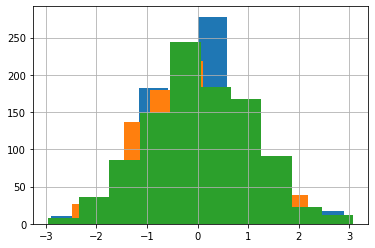

In [10]:
tests2.iloc[0][["boot_t_{}".format(i+1) for i in range(S)]].hist();
tests2.iloc[2][["boot_t_{}".format(i+1) for i in range(S)]].hist();
tests2.iloc[3][["boot_t_{}".format(i+1) for i in range(S)]].hist();

In [11]:
assert np.all(tests1.p_value < (0.05/M*E))
assert not np.all(tests2.p_value < (0.05/M*E))